<a href="https://colab.research.google.com/github/AbrahamB2603/IAyRN/blob/Main/DEFINITIVO1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
# ============================
# 1. Importar Librerías
# ============================
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

# Importamos librerías para el método de captura vía JavaScript en Colab.
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Librería para montar Google Drive en Colab.
from google.colab import drive

# Hola

In [81]:
# ============================
# 2. Montar Google Drive y Preprocesamiento
# ============================
# Montamos Google Drive para acceder al dataset.
drive.mount('/content/drive')

# Definimos la ruta al dataset en Drive.
# Se asume que tu dataset está organizado en:
# /content/drive/MyDrive/Datasets/Dataset/
# y que dentro existen subcarpetas (ej. 1, 2, 3, 4)
DATASET_PATH = "/content/drive/MyDrive/Datasets/Dataset"

# Verifica si la ruta existe para diagnosticar problemas.
if not os.path.exists(DATASET_PATH):
    print(f"Error: La ruta del dataset no existe: {DATASET_PATH}")
else:
    print("Contenido de la carpeta Dataset:", os.listdir(DATASET_PATH))

# Parámetros de preprocesamiento.
IMG_SIZE = (128,128)  # Se reduce la resolución para acelerar el entrenamiento.
BATCH_SIZE = 32       # Batch size moderado.

# Crea el dataset de entrenamiento y validación usando una partición 80/20.
try:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # Guardamos las clases detectadas antes de aplicar optimizaciones.
    class_names = train_ds.class_names

    # Optimización del pipeline: cache y prefetch para evitar cargas repetidas en memoria.
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    print("Clases detectadas:", class_names)

except Exception as e:
    print(f"Error al crear el dataset: {e}")
    print("Asegúrate de que la ruta del dataset es correcta y contiene subcarpetas.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contenido de la carpeta Dataset: ['Dedo 2', 'Dedo 3', 'Dedo 1', 'Dedo 4']
Found 825 files belonging to 4 classes.
Using 660 files for training.
Found 825 files belonging to 4 classes.
Using 165 files for validation.
Clases detectadas: ['Dedo 1', 'Dedo 2', 'Dedo 3', 'Dedo 4']


# Hola2

In [82]:
# ============================
# 3. Estructura y Entrenamiento de la RNAC
# ============================
if 'class_names' in locals() and class_names:
    NUM_CLASSES = len(class_names)

    # Arquitectura simplificada para acelerar el entrenamiento.
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE + (3,)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # Compilamos el modelo.
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Entrenamiento del modelo (se reducen los epochs a 5 para acelerar).
    EPOCHS = 8
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,116 (14.14 MB)

 Trainable params: 3,706,116 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3108 - loss: 380.9106 - val_accuracy: 0.7939 - val_loss: 0.5723
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 824ms/step - accuracy: 0.8347 - loss: 0.4812 - val_accuracy: 0.8364 - val_loss: 0.4097
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 809ms/step - accuracy: 0.9378 - loss: 0.2250 - val_accuracy: 0.8909 - val_loss: 0.3215
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 911ms/step - accuracy: 0.9774 - loss: 0.0910 - val_accuracy: 0.8182 - val_loss: 0.4400
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 817ms/step - accuracy: 0.9864 - loss: 0.0593 - val_accuracy: 0.9455 - val_loss: 0.2729
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 803ms/step - accuracy: 0.9998 - loss: 0.0072 - val_accuracy: 0.9273 - val_loss: 0.2529
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 801ms/step - accuracy: 0.9977 - loss: 0.0081 - val_accuracy: 0.9091 - val_loss: 0.2900
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 844ms/step - accuracy: 0.9986 - loss: 0.0131 - val_accuracy: 0.8

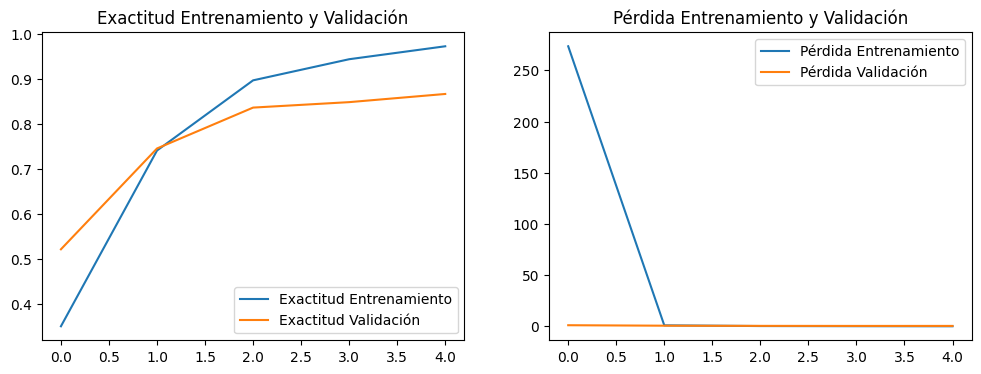

In [72]:
    # ============================
    # 4. Resultados de Exactitud de la RNAC
    # ============================
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Exactitud Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Exactitud Validación')
    plt.legend(loc='lower right')
    plt.title('Exactitud Entrenamiento y Validación')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida Entrenamiento y Validación')
    plt.savefig("/content/training_validation_metrics.png")
    plt.show()

<IPython.core.display.Javascript object>

Imagen guardada en: photo.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicción: Clase 3 ('Dedo 4') con confianza 90.6%


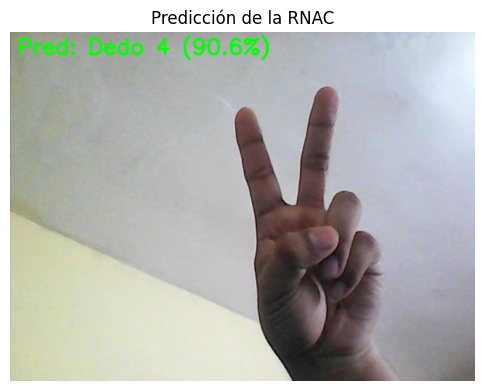

In [76]:
    # ============================
    # 5. Predicciones con la RNAC y Captura de Imagen desde la Webcam (Colab)
    # ============================
    # Función para capturar una foto usando JavaScript (compatible con Colab).
    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
          async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);
            const video = document.createElement('video');
            div.appendChild(video);
            document.body.appendChild(div);
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
          }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    # Capturamos la imagen con la webcam mediante el widget y la guardamos en "photo.jpg".
    filename = take_photo()
    print("Imagen guardada en:", filename)

    # Leemos la imagen capturada.
    captured_img = cv2.imread(filename)
    if captured_img is None:
        print("Error al leer la imagen capturada. Asegúrate de haber tomado la foto correctamente.")
    else:

        # Función para preprocesar la imagen (redimensionarla, cambiar color, expandir dimensiones).
        def preprocess_frame(frame):
            frame_resized = cv2.resize(frame, IMG_SIZE)
            frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
            frame_expanded = np.expand_dims(frame_rgb, axis=0)
            return frame_expanded

        # Preprocesamos la imagen capturada.
        photo_preprocessed = preprocess_frame(captured_img)

        # Realizamos la predicción usando el modelo entrenado.
        predictions = model.predict(photo_preprocessed)
        predicted_class_index = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        print(f"Predicción: Clase {predicted_class_index} ('{class_names[predicted_class_index]}') con confianza {confidence*100:.1f}%")

        # Agregamos la predicción sobre la imagen.
        annotated_img = captured_img.copy()
        cv2.putText(annotated_img,
                    f"Pred: {class_names[predicted_class_index]} ({confidence*100:.1f}%)",
                    (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2, cv2.LINE_AA)

        # Mostramos la imagen anotada usando matplotlib.
        annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(annotated_img_rgb)
        plt.axis('off')
        plt.title("Predicción de la RNAC")
        plt.show()


<IPython.core.display.Javascript object>

Imagen guardada en: photo.jpg


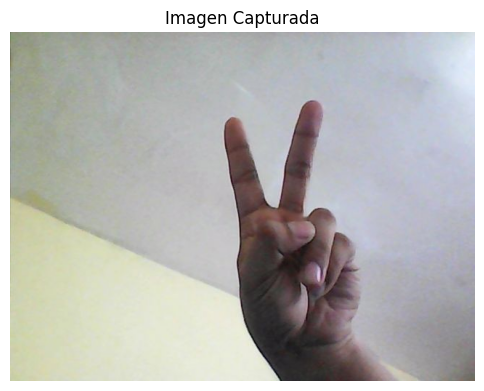

Forma de la imagen capturada: (480, 640, 3)
Forma de la imagen preprocesada: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicción: Clase 3 ('Dedo 4') con confianza 53.5%


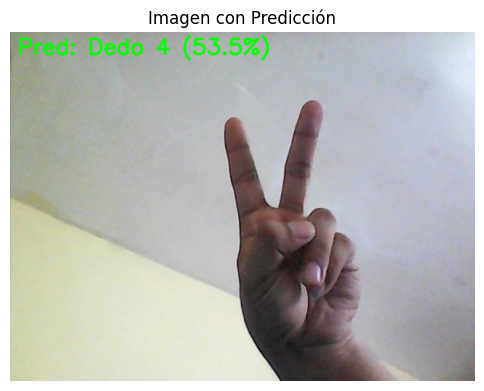

In [78]:
# ============================
# 5. Predicciones con la RNAC y Captura de Imagen desde la Webcam (Colab)
# ============================
# Función para capturar una foto usando JavaScript (compatible con Colab).
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);
        const video = document.createElement('video');
        div.appendChild(video);
        document.body.appendChild(div);
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await video.play();
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capturamos la imagen con la webcam mediante el widget y la guardamos en "photo.jpg".
filename = take_photo()
print("Imagen guardada en:", filename)

# Leemos la imagen capturada.
captured_img = cv2.imread(filename)
if captured_img is None:
    print("Error al leer la imagen capturada. Asegúrate de haber tomado la foto correctamente.")
else:
    # Mostrar la imagen capturada para depuración
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(captured_img, cv2.COLOR_BGR2RGB))
    plt.title("Imagen Capturada")
    plt.axis("off")
    plt.show()

    print("Forma de la imagen capturada:", captured_img.shape)

    # Función para preprocesar la imagen (redimensionarla, cambiar color, expandir dimensiones).
    def preprocess_frame(frame):
        frame_resized = cv2.resize(frame, IMG_SIZE)
        frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
        frame_expanded = np.expand_dims(frame_rgb, axis=0)
        return frame_expanded

    # Preprocesamos la imagen capturada.
    photo_preprocessed = preprocess_frame(captured_img)
    print("Forma de la imagen preprocesada:", photo_preprocessed.shape)

    # Realizamos la predicción usando el modelo entrenado.
    predictions = model.predict(photo_preprocessed)
    predicted_class_index = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    print(f"Predicción: Clase {predicted_class_index} ('{class_names[predicted_class_index]}') con confianza {confidence*100:.1f}%")

    # Agregamos la predicción sobre la imagen.
    annotated_img = captured_img.copy()
    cv2.putText(annotated_img,
                f"Pred: {class_names[predicted_class_index]} ({confidence*100:.1f}%)",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2, cv2.LINE_AA)

    # Mostrar la imagen anotada
    annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(annotated_img_rgb)
    plt.axis("off")
    plt.title("Imagen con Predicción")
    plt.show()



Ejemplo de Predicciones con Imágenes de Validación:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


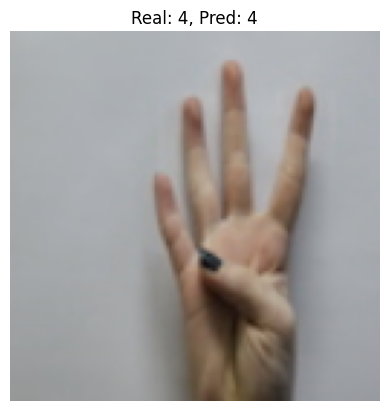

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


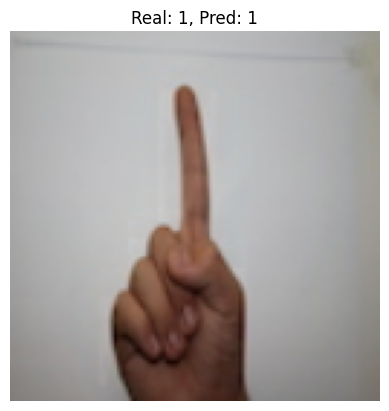

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


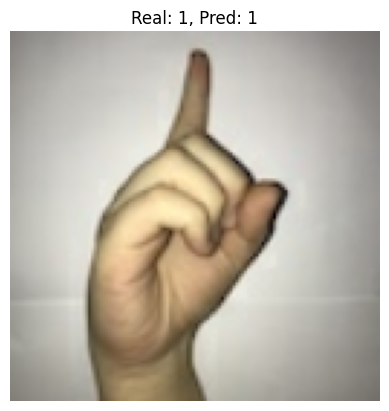


Skipping model training and subsequent steps because class_names was not successfully defined.


In [22]:
    # ============================
    # 6. Ejemplo de Predicciones con Imágenes de Validación
    # ============================
    if 'val_ds' in locals() and val_ds and 'class_names' in locals() and class_names:
        print("\nEjemplo de Predicciones con Imágenes de Validación:")
        for images, labels in val_ds.take(1):
            for i in range(min(3, images.shape[0])):
                image = images[i].numpy().astype("uint8")
                actual_label = labels[i].numpy()
                image_expanded = np.expand_dims(image, axis=0)
                prediction = model.predict(image_expanded)
                predicted_label_index = np.argmax(prediction[0])

                actual_label_name = class_names[actual_label] if actual_label < len(class_names) else f"Etiqueta {actual_label}"
                predicted_label_name = class_names[predicted_label_index] if predicted_label_index < len(class_names) else f"Clase {predicted_label_index}"

                plt.figure()
                plt.imshow(image)
                plt.title(f"Real: {actual_label_name}, Pred: {predicted_label_name}")
                plt.axis('off')
                plt.show()
    else:
         print("\nSkipping validation image predictions: val_ds or class_names not defined.")

    print("\nSkipping model training and subsequent steps because class_names was not successfully defined.")


# Hola3

In [ ]:
# ============================
# 3. Estructura y Entrenamiento de la RNAC
# ============================
if 'class_names' in locals() and class_names:
    NUM_CLASSES = len(class_names)

    # Arquitectura simplificada para acelerar el entrenamiento.
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE + (3,)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # Compilamos el modelo.
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Entrenamiento del modelo (se reducen los epochs a 5 para acelerar).
    EPOCHS = 5
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

    # ============================
    # 4. Resultados de Exactitud de la RNAC
    # ============================
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Exactitud Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Exactitud Validación')
    plt.legend(loc='lower right')
    plt.title('Exactitud Entrenamiento y Validación')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida Entrenamiento y Validación')
    plt.savefig("/content/training_validation_metrics.png")
    plt.show()

    # ============================
    # 5. Predicciones con la RNAC y Captura de Imagen desde la Webcam (Colab)
    # ============================
    # Función para capturar una foto usando JavaScript (compatible con Colab).
    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
          async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);
            const video = document.createElement('video');
            div.appendChild(video);
            document.body.appendChild(div);
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
          }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    # Capturamos la imagen con la webcam mediante el widget y la guardamos en "photo.jpg".
    filename = take_photo()
    print("Imagen guardada en:", filename)

    # Leemos la imagen capturada.
    captured_img = cv2.imread(filename)
    if captured_img is None:
        print("Error al leer la imagen capturada. Asegúrate de haber tomado la foto correctamente.")
    else:

        # Función para preprocesar la imagen (redimensionarla, cambiar color, expandir dimensiones).
        def preprocess_frame(frame):
            frame_resized = cv2.resize(frame, IMG_SIZE)
            frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
            frame_expanded = np.expand_dims(frame_rgb, axis=0)
            return frame_expanded

        # Preprocesamos la imagen capturada.
        photo_preprocessed = preprocess_frame(captured_img)

        # Realizamos la predicción usando el modelo entrenado.
        predictions = model.predict(photo_preprocessed)
        predicted_class_index = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        print(f"Predicción: Clase {predicted_class_index} ('{class_names[predicted_class_index]}') con confianza {confidence*100:.1f}%")

        # Agregamos la predicción sobre la imagen.
        annotated_img = captured_img.copy()
        cv2.putText(annotated_img,
                    f"Pred: {class_names[predicted_class_index]} ({confidence*100:.1f}%)",
                    (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2, cv2.LINE_AA)

        # Mostramos la imagen anotada usando matplotlib.
        annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(annotated_img_rgb)
        plt.axis('off')
        plt.title("Predicción de la RNAC")
        plt.show()

    # ============================
    # 6. Ejemplo de Predicciones con Imágenes de Validación
    # ============================
    if 'val_ds' in locals() and val_ds and 'class_names' in locals() and class_names:
        print("\nEjemplo de Predicciones con Imágenes de Validación:")
        for images, labels in val_ds.take(1):
            for i in range(min(3, images.shape[0])):
                image = images[i].numpy().astype("uint8")
                actual_label = labels[i].numpy()
                image_expanded = np.expand_dims(image, axis=0)
                prediction = model.predict(image_expanded)
                predicted_label_index = np.argmax(prediction[0])

                actual_label_name = class_names[actual_label] if actual_label < len(class_names) else f"Etiqueta {actual_label}"
                predicted_label_name = class_names[predicted_label_index] if predicted_label_index < len(class_names) else f"Clase {predicted_label_index}"

                plt.figure()
                plt.imshow(image)
                plt.title(f"Real: {actual_label_name}, Pred: {predicted_label_name}")
                plt.axis('off')
                plt.show()
    else:
         print("\nSkipping validation image predictions: val_ds or class_names not defined.")

else:
    print("\nSkipping model training and subsequent steps because class_names was not successfully defined.")
